In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#Getting the iris data frame
df = pd.read_csv('http://archive.ics.uci.edu/ml/'
                 'machine-learning-databases/iris/iris.data',header=None)

#Spliting dataset, each dataset has same class-ratio (training data : setosa40, versicolor40, virginica40 / test data : setosa10, versicolor10, virginica10)
setosa = df.iloc[:50,:].values
versicolor = df.iloc[50:100,:].values
virginica = df.iloc[100:150,:].values
np.random.shuffle(setosa)
np.random.shuffle(versicolor)
np.random.shuffle(virginica)

x_train = np.concatenate((setosa[:40,[0,2]], versicolor[:40,[0,2]], virginica[:40,[0,2]])).astype(np.float64)
y_train = np.concatenate((setosa[:40, 4], versicolor[:40, 4], virginica[:40, 4]))
y_train = np.where(y_train=='Iris-virginica', 2, 
                  np.where(y_train=='Iris-versicolor', 1, 0))

x_test = np.concatenate((setosa[40:,[0,2]], versicolor[40:,[0,2]], virginica[40:,[0,2]])).astype(np.float64)
y_test = np.concatenate((setosa[40:, 4], versicolor[40:, 4], virginica[40:, 4]))
y_test = np.where(y_test=='Iris-virginica', 2, 
                  np.where(y_test=='Iris-versicolor', 1, 0))


#Standardizing features
x_train_std = np.copy(x_train)
x_test_std = np.copy(x_test)

x_train_std[:, 0] = (x_train[:, 0]-x_train[:, 0].mean()) / x_train[:, 0].std()
x_train_std[:, 1] = (x_train[:, 1]-x_train[:, 1].mean()) / x_train[:, 0].std()
x_test_std[:, 0] = (x_test[:, 0]-x_test[:, 0].mean()) / x_test[:, 0].std()
x_test_std[:, 1] = (x_test[:, 1]-x_test[:, 1].mean()) / x_test[:, 0].std()

#combining feature
x_combined_std = np.concatenate((x_train_std, x_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

In [14]:
#Define AdalineSGD class
class AdalineSGD(object):
    #Initializing module
    def __init__(self, learning_rate=0.01, shuffle=True, epochs=50, random_state=1, batch_size=120, adap_learning = False):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        self.batch_size=batch_size
        self.adap_learning = adap_learning
    
    #Training module
    def training(self, X, y):
        self._initialize_weights(X.shape[1])  
        self.cost_=[]
        self.cost_test_= []
        self.accuracy_ = []
        self.accuracy_test_ = []
        self.miscls_ = []
        self.miscls_test_ = []
        self.adap_learning_rate = []
        
        for i in range(self.epochs):
            predict_list = []
            predict_list_test = []
            cost = []
            cost_test = []
            total_batch = int(X.shape[0]/self.batch_size)
    
            #Calculating accuracy for the train data
            for xi, target in zip(x_train_std, y_train):
                predict_list.append(np.equal(self.predict(xi),target))
            self.accuracy_.append(np.mean(predict_list))
            self.miscls_.append(1-np.mean(predict_list))
            #Calculating accuracy for the test data
            for xi, target in zip(x_test_std, y_test):
                predict_list_test.append(np.equal(self.predict(xi),target))
            self.accuracy_test_.append(np.mean(predict_list_test))
            self.miscls_test_.append(1-np.mean(predict_list_test))
            
            #Calculating the cost for the test data
            for xi, target in zip(x_test_std, y_test):
                c, e = self.cost_function(xi, target)
                cost_test.append(c)
            avg_cost_test = np.mean(cost_test)
            self.cost_test_.append(avg_cost_test)
            
            #Calculating the first cost for the training data
            if i == 0:
                for xi, target in zip(x_train_std, y_train):
                    c, e = self.cost_function(xi, target)
                    cost.append(c)
                avg_cost = np.mean(cost)
                self.cost_.append(avg_cost)
            
            #Mini-batch learning iteration
            for j in range(total_batch):
                if self.shuffle:
                    s_X, s_y = self._shuffle(X,y)
                b_X = s_X[0:self.batch_size]
                b_y = s_y[0:self.batch_size]
                for xi, target in zip(b_X, b_y): 
                    c = self._update_weights(xi, target)
                    cost.append(c)
            avg_cost = np.mean(cost)
            self.cost_.append(avg_cost)
            
            #Aaptive learning
            if self.adap_learning:
                self.adap_learning_rate.append(self.learning_rate)
                self.learning_rate = self.learning_rate * (0.01**(1/self.epochs))
                    
                  
        self.final_accuracy = self.accuracy_[self.epochs-1]
        return self
    
    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state) # random number generator for weight initialize
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1+m) # initialize weight to normal distribution randomly
        self.w_initialized = True
    
    def cost_function(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = (target - output)
        cost = 0.5 * error**2
        return (cost, error)
      
    def _update_weights(self, xi, target):
        cost, error = self.cost_function(xi, target)
        self.w_[1:] += self.learning_rate * xi.dot(error)
        self.w_[0] += self.learning_rate * error
        return cost
        
    #Network input = W*X+b
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    #Linear activation
    def activation(self, X):
        return X
    
    #Prediction module
    def predict(self, X):
        return np.where(self.activation(self.net_input(X))>=1.5, 2, 
                        np.where(self.activation(self.net_input(X))>=0.6, 1, 0))

In [15]:
#Plotting decision region module
def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    labels = ('Setosa', 'Versicolor', 'Virginica')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #Plotting learning rate if adap_learning = True
    if classifier.adap_learning:
        plt.plot(range(1, len(classifier.adap_learning_rate)+1), classifier.adap_learning_rate, label='learning rate')
        plt.xlabel('Epochs')
        plt.ylabel('Learning rate')
        plt.title("Adaptive learning rate")
        plt.legend(loc='center right')
        plt.show()
        print("The first learning rate : ",classifier.adap_learning_rate[0])
        print("The lasst learning rate : ",classifier.adap_learning_rate[-1])
    
    plt.figure(figsize=(10,10)).patch.set_facecolor('xkcd:mint green')
    
    #Plotting decision boundary for test data
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), 
                                np.arange(x2_min, x2_max, resolution))
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    plt.subplot(2,2,1)
    plt.contourf(xx1, xx2, z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0],
                    y=X[y==cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=labels[idx],
                    edgecolor='black')
    plt.title("Test data")
    plt.legend()
    plt.grid()
    
    #Plotting decision boundary for training data
    x1_min, x1_max = x_train_std[:, 0].min() - 1, x_train_std[:, 0].max() + 1
    x2_min, x2_max = x_train_std[:, 1].min() - 1, x_train_std[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), 
                                np.arange(x2_min, x2_max, resolution))
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    plt.subplot(2,2,2)
    plt.contourf(xx1, xx2, z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y_train)):
        plt.scatter(x=x_train_std[y_train==cl, 0],
                    y=x_train_std[y_train==cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=labels[idx],
                    edgecolor='black')
    plt.title("Training data")
    plt.legend()
    plt.grid()
    
    #Plotting cost curves
    plt.subplot(2,2,3)
    plt.plot(range(1, len(classifier.cost_)+1), classifier.cost_, label='cost')
    plt.plot(range(1, len(classifier.cost_test_)+1), classifier.cost_test_, label='cost_test')
    plt.xlabel('Epochs')
    plt.ylabel('Average Cost')
    plt.title("Learning curves")
    plt.legend(loc='center right')
    plt.grid()
    
    #Plotting accuracy/misclassificaion ratio curves
    plt.subplot(2,2,4)
    plt.plot(range(1, len(classifier.accuracy_)+1), classifier.accuracy_, label='acc_train')
    plt.plot(range(1, len(classifier.accuracy_test_)+1), classifier.accuracy_test_, label='acc_test')
    plt.plot(range(1, len(classifier.miscls_)+1), classifier.miscls_, label='mis_train')
    plt.plot(range(1, len(classifier.miscls_test_)+1), classifier.miscls_test_, label='mis_test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy / misclassfication ratio')
    plt.ylim(0,1)
    plt.title("Accuracy & misclassificaion ratio curves")
    plt.legend(loc='center right')
    plt.grid()
      

In [16]:
model1 = AdalineSGD(epochs=100, learning_rate=0.1)
model1.training(x_train_std, y_train)
model2 = AdalineSGD(epochs=100, learning_rate=0.01)
model2.training(x_train_std, y_train)
model3 = AdalineSGD(epochs=100, learning_rate=0.001)
model3.training(x_train_std, y_train)
model4 = AdalineSGD(epochs=100, learning_rate=0.0001)
model4.training(x_train_std, y_train)

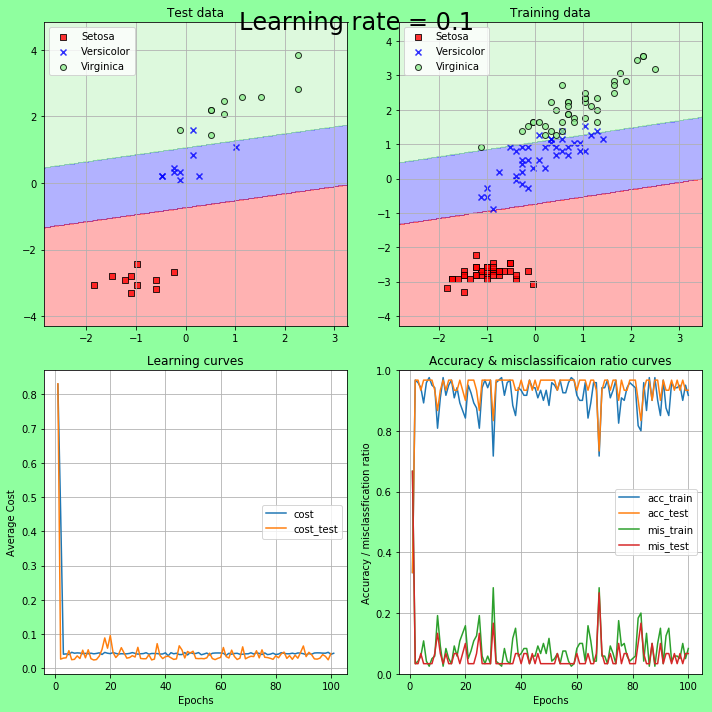

Accuracy :  91.6666666667 %


In [17]:
#model1 plot
plot_decision_regions(X=x_test_std, y=y_test, classifier = model1)
plt.tight_layout()
plt.suptitle('Learning rate = 0.1', fontsize=24)
plt.show()
print('Accuracy : ', model1.final_accuracy*100,'%')

*Learning rate(eta)가 0.1인 경우*
초반 epoch에서는 cost가 잘떨어지지만 너무 큰 learning rate로 인해
어느정도 떨어진 후에는 발산을 하게 된다. 
정확도와 오분류율 또한 초반에만 개선되는게 보이고 상승과 하락을 반복하며 발산하는 모습을 보인다.
최종 accuracy는 발산 하기 때문에 높다가 다음에 돌리면 낮을때도 있고 일정하지 않다.

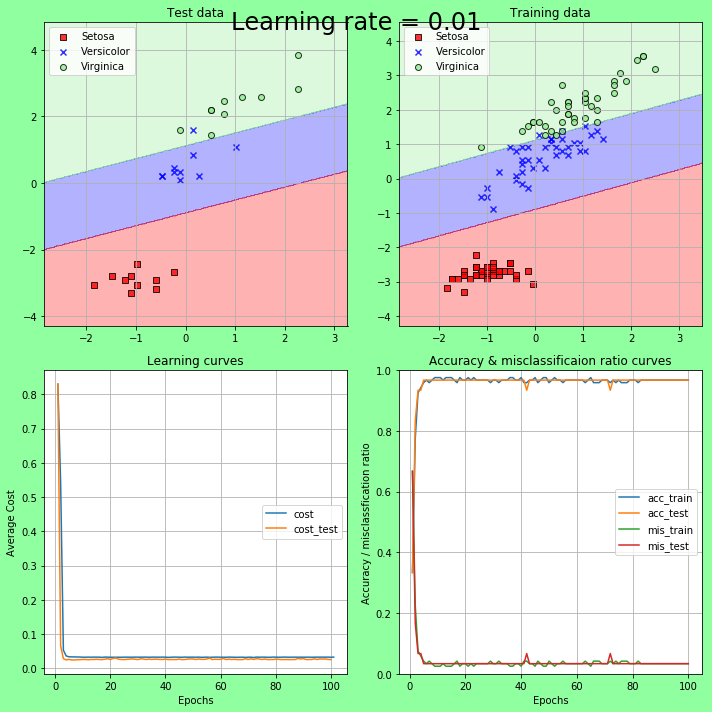

Accuracy :  96.6666666667 %


In [18]:
#model2 plot
plot_decision_regions(X=x_test_std, y=y_test, classifier = model2)
plt.tight_layout()
plt.suptitle('Learning rate = 0.01', fontsize=24)
plt.show()
print('Accuracy : ', model2.final_accuracy*100,'%')

*Learning rate(eta)가 0.01인 경우*
cost가 빠르게 0에 가까이 수렴하는 모습을 보이며, 
정확도와 오분류율 또한 각각 증가 감소가 잘된다.

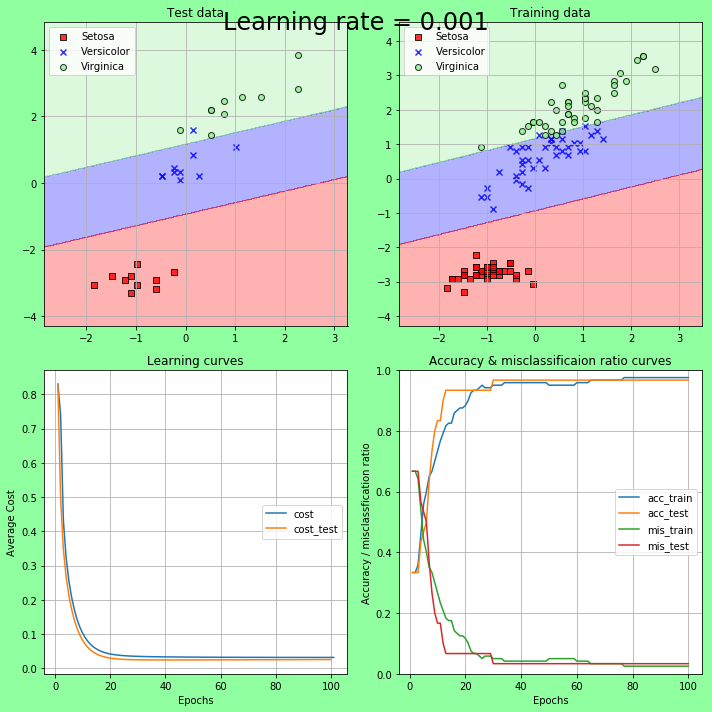

Accuracy :  97.5 %


In [19]:
#model3 plot
plot_decision_regions(X=x_test_std, y=y_test, classifier = model3)
plt.tight_layout()
plt.suptitle('Learning rate = 0.001', fontsize=24)
plt.show()
print('Accuracy : ', model3.final_accuracy*100,'%')

*Learning rate(eta)가 0.001인 경우*
cost가 learning rate가 0.01일때보다 좀 epoch이 더 지난 후 0에 가까이 수렴하는 모습을 보이며, 
정확도와 오분류율 또한 learining rate = 0.01 일때 보다 각각 증가/감소가 상대적으로 느린 모습이다.

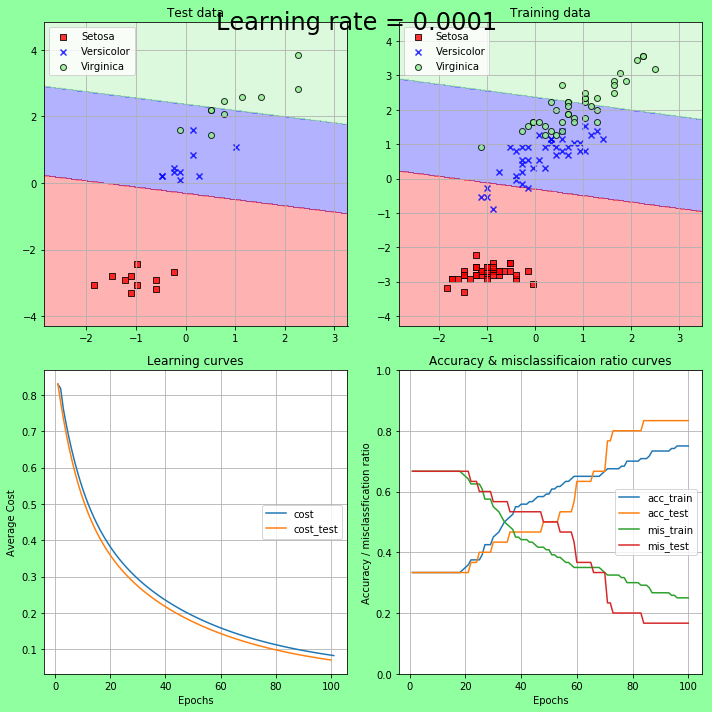

Accuracy :  75.0 %


In [20]:
#model4 plot
plot_decision_regions(X=x_test_std, y=y_test, classifier = model4)
plt.tight_layout()
plt.suptitle('Learning rate = 0.0001', fontsize=24)
plt.show()
print('Accuracy : ', model4.final_accuracy*100,'%')

*Learning rate(eta)가 0.0001인 경우*
learning rate가 너무 작은 나머지 cost가 수렴하지 못했다. 
정확도와 오분류율도 다른 learning rate들의 최종결과에 비해 다소 안 좋아 보인다.
decision boundary만 보아도 test set에 대해 오차가 상대적으로 많다.

In [21]:
model5 = AdalineSGD(epochs=100, learning_rate=0.001, batch_size=1)
model5.training(x_train_std, y_train)
model6 = AdalineSGD(epochs=100, learning_rate=0.001, batch_size=2)
model6.training(x_train_std, y_train)
model7 = AdalineSGD(epochs=100, learning_rate=0.001, batch_size=4)
model7.training(x_train_std, y_train)
model8 = AdalineSGD(epochs=100, learning_rate=0.001, batch_size=8)
model8.training(x_train_std, y_train)
model9 = AdalineSGD(epochs=100, learning_rate=0.001, batch_size=16)
model9.training(x_train_std, y_train)
model10 = AdalineSGD(epochs=100, learning_rate=0.001, batch_size=32)
model10.training(x_train_std, y_train)

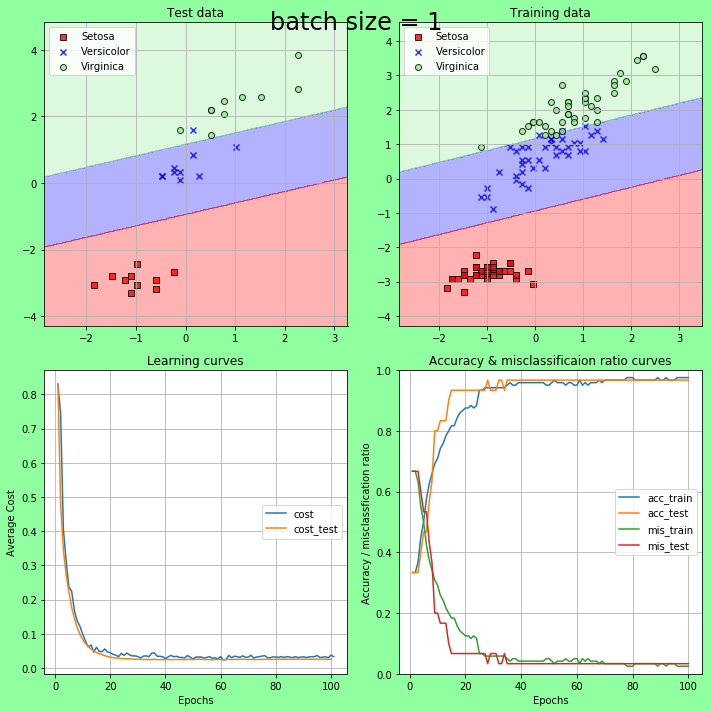

Accuracy :  97.5 %


In [22]:
#model5 plot
plot_decision_regions(X=x_test_std, y=y_test, classifier = model5)
plt.tight_layout()
plt.suptitle('batch size = 1', fontsize=24)
plt.show()
print('Accuracy : ', model5.final_accuracy*100,'%')

*batch size가 1인 경우*
cost update가 너무 자주 일어나서 cost가 크게보면 내려 가기는하지만 변동폭이 크다.

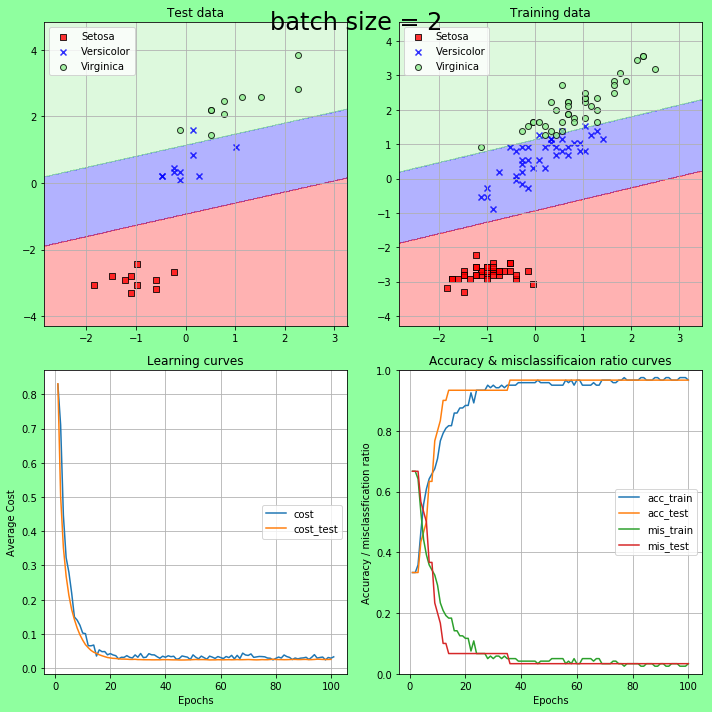

Accuracy :  96.6666666667 %


In [23]:
#model6 plot
plot_decision_regions(X=x_test_std, y=y_test, classifier = model6)
plt.tight_layout()
plt.suptitle('batch size = 2', fontsize=24)
plt.show()
print('Accuracy : ', model6.final_accuracy*100,'%')

*batch size가 2인 경우*
batch size가 1인 경우와 마찬가지로 변동폭이 매우 크다.

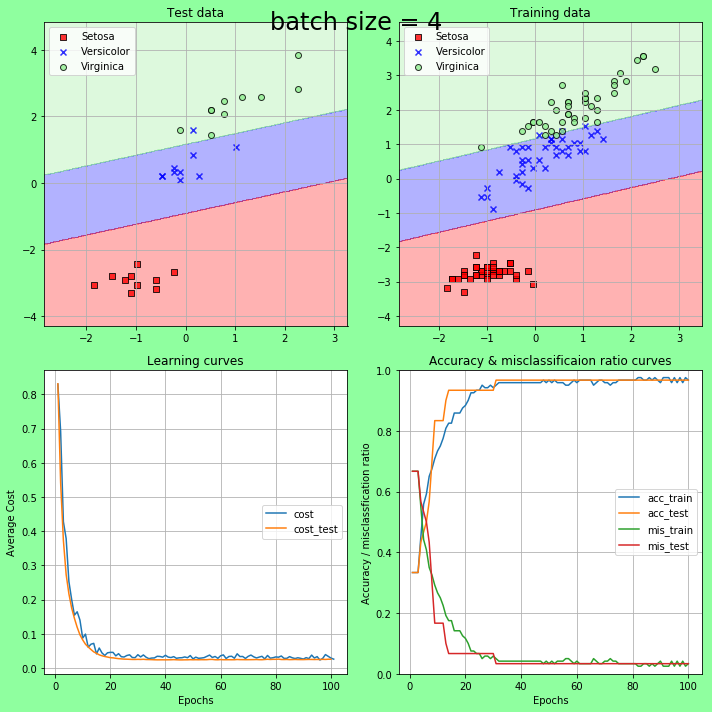

Accuracy :  96.6666666667 %


In [24]:
#model7 plot
plot_decision_regions(X=x_test_std, y=y_test, classifier = model7)
plt.tight_layout()
plt.suptitle('batch size = 4', fontsize=24)
plt.show()
print('Accuracy : ', model7.final_accuracy*100,'%')

*batch size가 4인 경우*
앞서 보았던 batch size들 보다는 요동이 적지만 여전히 심해보인다.

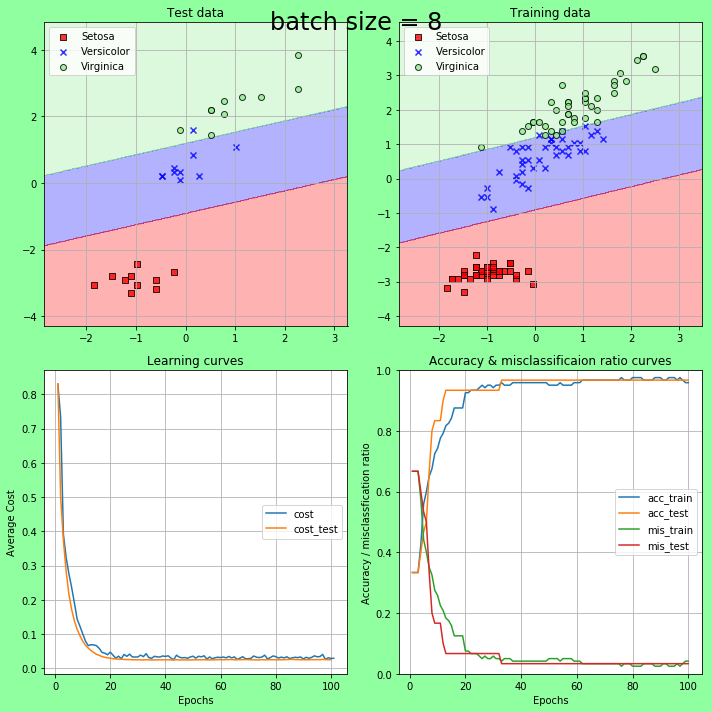

Accuracy :  95.8333333333 %


In [25]:
#model8 plot
plot_decision_regions(X=x_test_std, y=y_test, classifier = model8)
plt.tight_layout()
plt.suptitle('batch size = 8', fontsize=24)
plt.show()
print('Accuracy : ', model8.final_accuracy*100,'%')

*batch size가 8인 경우*
cost가 요동치는게 좀 적어졌다.

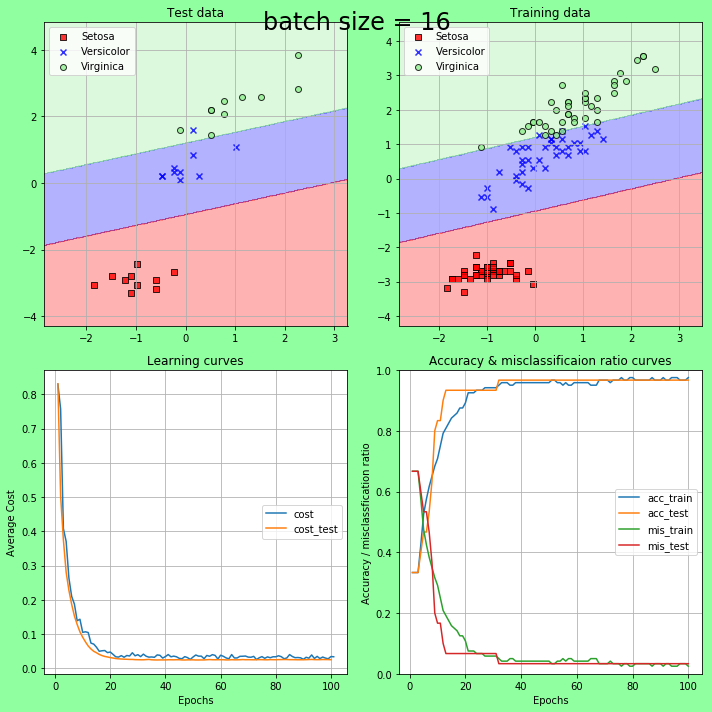

Accuracy :  97.5 %


In [26]:
#model9 plot
plot_decision_regions(X=x_test_std, y=y_test, classifier = model9)
plt.tight_layout()
plt.suptitle('batch size = 16', fontsize=24)
plt.show()
print('Accuracy : ', model9.final_accuracy*100,'%')

*batch size가 16인 경우*
cost가 훨씬 안정적이 되었지만 여전히 요동치는 curves가 나온다.

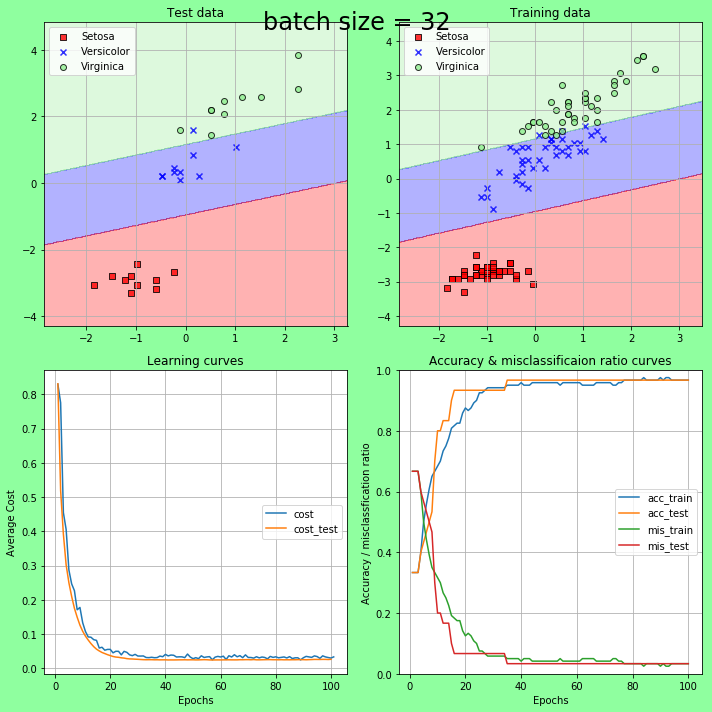

Accuracy :  96.6666666667 %


In [27]:
#model10 plot
plot_decision_regions(X=x_test_std, y=y_test, classifier = model10)
plt.tight_layout()
plt.suptitle('batch size = 32', fontsize=24)
plt.show()
print('Accuracy : ', model10.final_accuracy*100,'%')

*batch size가32인 경우*
가장 진동하는 것이 적으며, batch size가 커질수록 cost의 변동폭이 작아진다는 것을 알 수 있다.

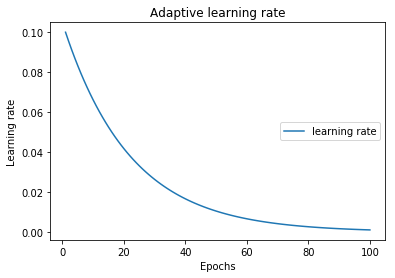

The first learning rate :  0.1
The lasst learning rate :  0.001047128548050906


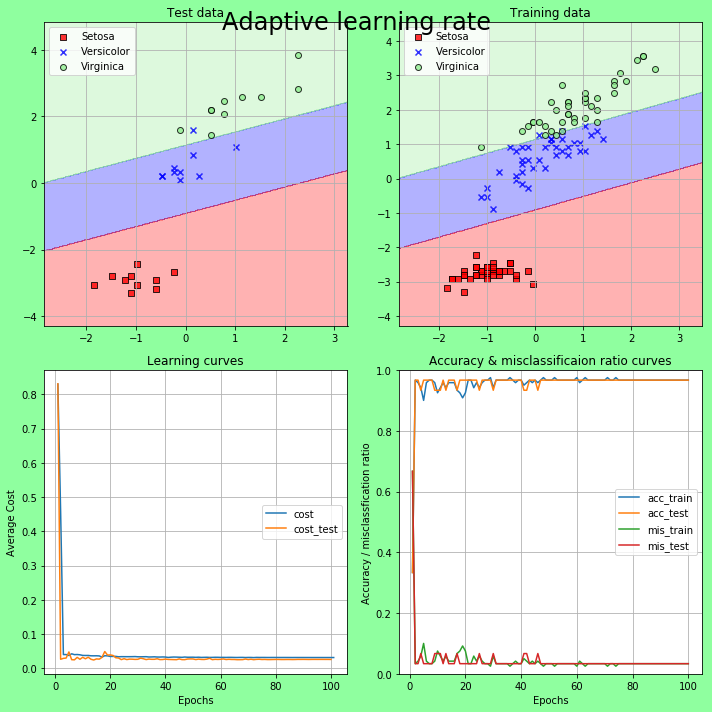

Accuracy :  96.6666666667 %


In [29]:
#Adaptive learning rate model
adap_model = AdalineSGD(epochs=100, learning_rate=0.1, adap_learning=True)
adap_model.training(x_train_std, y_train)
plot_decision_regions(X=x_test_std, y=y_test, classifier = adap_model)
plt.tight_layout()
plt.suptitle('Adaptive learning rate', fontsize=24)
plt.show()
print('Accuracy : ', adap_model.final_accuracy*100,'%')

*Adaptive learning rate를 적용한 경우*
매 epoch마다 조금씩 learning rate가 감소하여 0.1~0.001까지 줄어 들도록 설정 하였다.
learning curves나 accuracy/misclassification ratio curves를 보면 부분 부분 learning rate가 다른 모델을 섞은듯한 느낌이 든다.